In [1]:
import torch
from torch_geometric.datasets import QM9
dataset = QM9(root="../data/QM9")

/home/alex/miniconda3/envs/torch28/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print('=============================================================')

# Gather some statistics about the first graph.
data = dataset[0]  # Get the first graph object.
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: QM9(130831):
Number of graphs: 130831
Number of features: 11
Number of classes: 19
Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])
Number of nodes: 5
Number of edges: 8
Average node degree: 1.60
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [5]:
from torch_geometric.loader import DataLoader

torch.manual_seed(117)
dataset = dataset.shuffle()

# Training/test split
training_perc = 0.9
train_dataset = dataset[:int(len(dataset) * training_perc)]
test_dataset = dataset[int(len(dataset) * training_perc):]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Number of training graphs: 117747
Number of test graphs: 13084


In [36]:
target_idx = 11  # index of the target property to predict (Cv - Heat capacity)

# Normalization for the training set
ys_train = torch.stack([d.y for d in train_dataset])[:, 0, target_idx]
train_mean = ys_train.mean()
train_std = ys_train.std()
if train_std == 0:
    train_std = 1.0

print(f"Target statistics - Mean: {train_mean:.4f}, Std: {train_std:.4f}")

Target statistics - Mean: 31.6127, Std: 4.0648


### Simple model

In [12]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(117)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(11, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=1, bias=True)
)


### Improved model

In [30]:
# Improved Architecture Example - Uses edge features and more layers

from torch.nn import Linear, BatchNorm1d
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, global_add_pool

class ImprovedGCN(torch.nn.Module):
    def __init__(self, hidden_channels=128, num_layers=4):
        super().__init__()
        torch.manual_seed(117)
        
        # More layers for better representation
        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()
        
        # First layer
        self.convs.append(GCNConv(dataset.num_node_features, hidden_channels))
        self.batch_norms.append(BatchNorm1d(hidden_channels))
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
            self.batch_norms.append(BatchNorm1d(hidden_channels))
        
        # Output layers with dropout
        self.lin1 = Linear(hidden_channels, hidden_channels // 2)
        self.lin2 = Linear(hidden_channels // 2, 1)
        self.dropout = 0.3

    def forward(self, x, edge_index, batch, edge_attr=None):
        # Graph convolution layers with residual connections
        for i, (conv, bn) in enumerate(zip(self.convs, self.batch_norms)):
            x_new = conv(x, edge_index)
            x_new = bn(x_new)
            x_new = F.relu(x_new)
            
            # Skip connection after first layer
            if i > 0 and x.size(-1) == x_new.size(-1):
                x = x + x_new
            else:
                x = x_new
        
        # Global pooling (try both mean and sum)
        x = global_mean_pool(x, batch)
        
        # Final prediction layers
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin2(x)
        
        return x

# Quick test of the improved model
improved_model = ImprovedGCN(hidden_channels=128, num_layers=5)
print("Improved Model Architecture:")
print(improved_model)
print(f"\nParameters: {sum(p.numel() for p in improved_model.parameters()):,}")

Improved Model Architecture:
ImprovedGCN(
  (convs): ModuleList(
    (0): GCNConv(11, 128)
    (1-4): 4 x GCNConv(128, 128)
  )
  (batch_norms): ModuleList(
    (0-4): 5 x BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=1, bias=True)
)

Parameters: 77,185


### Train

In [ ]:
# Model, optimizer, loss, scheduler
model = ImprovedGCN(hidden_channels=128, num_layers=5)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = torch.nn.L1Loss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

def train():
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch).view(-1)
        y_norm = (data.y[:, target_idx] - train_mean) / train_std
        loss = criterion(out, y_norm)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        running_loss += loss.item() * y_norm.size(0)
    return running_loss / len(train_loader.dataset)
    

def evaluate(loader):
    model.eval()
    with torch.no_grad():
        mae = 0.0
        n = 0
        for data in loader:
            out = model(data.x, data.edge_index, data.batch).view(-1)
            out_denorm = out * train_std + train_mean
            y = data.y[:, target_idx]
            mae += torch.sum(torch.abs(out_denorm - y)).item()
            n += y.size(0)
    return mae / n

# Early stopping + checkpointing training loop
max_epochs = 500
patience = 20
min_delta = 1e-4
best_val = float('inf')
epochs_no_improve = 0
save_path = "model_improved.pt"

print("Starting training...")
for epoch in range(1, max_epochs + 1):
    train_loss = train()
    train_mae = evaluate(train_loader)
    val_mae = evaluate(test_loader)
    scheduler.step(val_mae)

    # Check for improvement and checkpoint
    if val_mae < best_val - min_delta:
        best_val = val_mae
        epochs_no_improve = 0
        torch.save(model.state_dict(), save_path)
        improved = " *"
    else:
        epochs_no_improve += 1
        improved = ""

    if epoch % 5 == 0 or epochs_no_improve == 0:
        print(f"[*] Epoch {epoch:03d}  Train loss: {train_loss:.4f}  Train MAE: {train_mae:.4f}  Val MAE: {val_mae:.4f}{improved}")

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch} (no val MAE improvement for {patience} epochs).")
        break

# Load best model for final evaluation
model.load_state_dict(torch.load(save_path))
final_val = evaluate(test_loader)
print(f"\nFinal Results:")
print(f"Best validation MAE: {best_val:.4f}")
print(f"Final evaluated MAE: {final_val:.4f}")
print(f"Test set mean: {train_mean:.4f}, std: {train_std:.4f}")
print(f"Relative MAE: {(best_val/train_std.abs()):.4f} standard deviations")

# Compare to baseline (predicting mean)
baseline_mae = train_std.abs().item()
print(f"Baseline MAE (predicting mean): {baseline_mae:.4f}")
print(f"Improvement over baseline: {(baseline_mae/best_val):.2f}x")

Target statistics - Mean: 31.6222, Std: 4.0711
Starting training...
[Improved] Epoch 001  Train loss: 0.4112  Train MAE: 1.3588  Val MAE: 1.3465 *
[Improved] Epoch 002  Train loss: 0.3823  Train MAE: 1.2857  Val MAE: 1.2683 *
[Improved] Epoch 004  Train loss: 0.3694  Train MAE: 1.2584  Val MAE: 1.2473 *
[Improved] Epoch 005  Train loss: 0.3667  Train MAE: 1.3682  Val MAE: 1.3622
[Improved] Epoch 006  Train loss: 0.3610  Train MAE: 1.2394  Val MAE: 1.2197 *
[Improved] Epoch 009  Train loss: 0.3484  Train MAE: 1.2119  Val MAE: 1.1854 *
[Improved] Epoch 010  Train loss: 0.3431  Train MAE: 1.2657  Val MAE: 1.2633
[Improved] Epoch 014  Train loss: 0.3337  Train MAE: 1.1448  Val MAE: 1.1262 *
[Improved] Epoch 015  Train loss: 0.3309  Train MAE: 1.1763  Val MAE: 1.1610
[Improved] Epoch 016  Train loss: 0.3292  Train MAE: 1.1236  Val MAE: 1.1033 *
[Improved] Epoch 017  Train loss: 0.3268  Train MAE: 1.1161  Val MAE: 1.0948 *
[Improved] Epoch 020  Train loss: 0.3203  Train MAE: 1.1046  Val MAE:

TypeError: evaluate() missing 2 required positional arguments: 'mean' and 'std'

### Load the model

In [33]:
model = ImprovedGCN(hidden_channels=128, num_layers=5)
save_path = "model_improved.pt"
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

### Predicting

In [39]:
def predict(data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.batch).view(-1)
        out_denorm = out * train_std + train_mean
        y = data.y[:, target_idx]
    return out_denorm, y

sample_data = test_dataset[200]
predicted, actual = predict(sample_data)
print(f"Predicted: {predicted.item():.4f}, Actual: {actual.item():.4f}")

Predicted: 34.4335, Actual: 34.9340


### Testing the performance

In [41]:
# Make a simple model, like a lineal regression, to compare it to our model
# Simple linear regression baseline on pooled node features
in_feats = dataset.num_node_features
simple_model = torch.nn.Linear(in_feats, 1)
optimizer = torch.optim.Adam(simple_model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = torch.nn.L1Loss()

def train_simple(epochs=50):
    simple_model.train()
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        for data in train_loader:
            optimizer.zero_grad()
            feats = global_mean_pool(data.x, data.batch)  # [batch_size, in_feats]
            out = simple_model(feats).view(-1)
            y_norm = (data.y[:, target_idx] - train_mean) / train_std
            loss = criterion(out, y_norm)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * y_norm.size(0)
        if epoch % 10 == 0:
            print(f"[Simple] Epoch {epoch:03d}  Train loss: {running_loss/len(train_loader.dataset):.4f}")

def evaluate_simple(loader):
    simple_model.eval()
    with torch.no_grad():
        mae = 0.0
        n = 0
        for data in loader:
            feats = global_mean_pool(data.x, data.batch)
            out = simple_model(feats).view(-1)
            out_denorm = out * train_std + train_mean
            y = data.y[:, target_idx]
            mae += torch.sum(torch.abs(out_denorm - y)).item()
            n += y.size(0)
    return mae / n

# Train and evaluate the simple baseline
train_simple(epochs=50)
train_mae_simple = evaluate_simple(train_loader)
test_mae_simple = evaluate_simple(test_loader)
print(f"Simple linear regression MAE - Train: {train_mae_simple:.4f}, Test: {test_mae_simple:.4f}")

[Simple] Epoch 010  Train loss: 0.5681
[Simple] Epoch 020  Train loss: 0.5656
[Simple] Epoch 030  Train loss: 0.5655
[Simple] Epoch 040  Train loss: 0.5655
[Simple] Epoch 050  Train loss: 0.5656
Simple linear regression MAE - Train: 2.2984, Test: 2.3177


In [43]:
# Our model performance
def evaluate(loader):
    model.eval()
    with torch.no_grad():
        mae = 0.0
        n = 0
        for data in loader:
            out = model(data.x, data.edge_index, data.batch).view(-1)
            out_denorm = out * train_std + train_mean
            y = data.y[:, target_idx]
            mae += torch.sum(torch.abs(out_denorm - y)).item()
            n += y.size(0)
    return mae / n

model = ImprovedGCN(hidden_channels=128, num_layers=5)
model.load_state_dict(torch.load("model_improved.pt"))
train_mae_model = evaluate(train_loader)
test_mae_model = evaluate(test_loader)
print(f"Improved GCN MAE - Train: {train_mae_model:.4f}, Test: {test_mae_model:.4f}")

Improved GCN MAE - Train: 0.4859, Test: 0.4790


In [ ]:
def predict(data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.batch).view(-1)
        out_denorm = out * train_std + train_mean
        y = data.y[:, target_idx]
    return out_denorm, y

sample_data = test_dataset[200]
predicted, actual = predict(sample_data)
print(f"Predicted: {predicted.item():.4f}, Actual: {actual.item():.4f}")

0.4789996268150822

R² score on test set: 0.9398


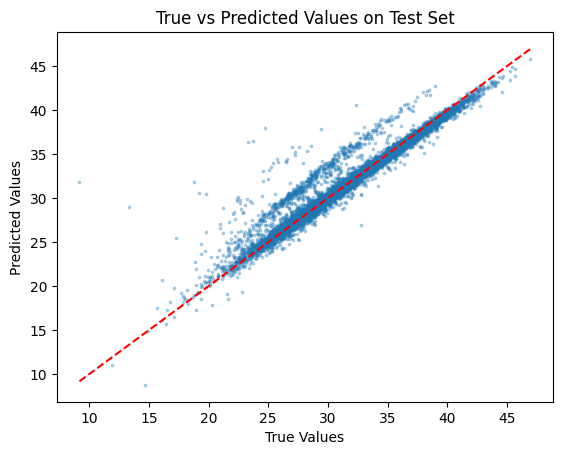

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def compare_ytrue_ypred(loader):
    model.eval()
    ypred = []
    ytrue = []
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch).view(-1)
            out_denorm = out * train_std + train_mean
            y = data.y[:, target_idx]
            ypred.append(out_denorm)
            ytrue.append(y)
    return ytrue, ypred

ytrue, ypred = compare_ytrue_ypred(test_loader)
ytrue = torch.cat(ytrue).cpu().numpy()
ypred = torch.cat(ypred).cpu().numpy()

# Calculate R² score
r2 = r2_score(ytrue, ypred)
print(f"R² score on test set: {r2:.4f}")

# Plot true vs predicted valuesS
plt.scatter(ytrue, ypred, alpha=0.3, s=3)
plt.plot([ytrue.min(), ytrue.max()], [ytrue.min(), ytrue.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values on Test Set")
plt.show()

In [ ]:
from pprint import pprint

# Find test entries where predicted / true > 1.1 and return details
ratio = ypred / ytrue
mask = ratio > 1.1
indices = mask.nonzero()[0]

print(f"Found {len(indices)} entries with ypred/ytrue > 1.1")

# Collect results: (index_in_test_set, optional_name, y_true, y_pred, ratio)
results = []
entries = []
for idx in indices:
    yi = float(ytrue[idx])
    yp = float(ypred[idx])
    r = float(ratio[idx])
    name = None
    try:
        # try to read a name if present in the dataset entry
        entry = test_dataset[idx]
        name = entry.name if hasattr(entry, "name") else None
    except Exception:
        name = None
        entry = None
    results.append((int(idx), name, yi, yp, r))
    entries.append(entry)

# Expose results and show the first 50 for inspection
high_ratio_results = results
high_ratio_entries = entries
pprint(high_ratio_results[:50]) 

Found 9 entries with ypred/ytrue > 1.1
[(39, 'gdb_320', 19.78499984741211, 30.46082305908203, 1.5395917892456055),
 (1021, 'gdb_314', 23.31399917602539, 36.37456130981445, 1.5602025985717773),
 (1103, 'gdb_104', 19.17300033569336, 30.561555862426758, 1.5939892530441284),
 (1161, 'gdb_17', 9.175999641418457, 31.792768478393555, 3.4647743701934814),
 (4950, 'gdb_712', 17.26799964904785, 25.416629791259766, 1.47189199924469),
 (6034, 'gdb_657', 18.77199935913086, 31.839611053466797, 1.6961225271224976),
 (8861, 'gdb_52', 13.357999801635742, 29.004953384399414, 2.1713545322418213),
 (9171, 'gdb_3198', 23.683000564575195, 36.53126525878906, 1.5425100326538086),
 (9473, 'gdb_313', 24.722999572753906, 37.97164535522461, 1.5358834266662598)]


In [197]:
high_ratio_entries

[Data(x=[13, 11], edge_index=[2, 28], edge_attr=[28, 4], y=[1, 19], pos=[13, 3], idx=[1], name='gdb_320', z=[13]),
 Data(x=[15, 11], edge_index=[2, 30], edge_attr=[30, 4], y=[1, 19], pos=[15, 3], idx=[1], name='gdb_314', z=[15]),
 Data(x=[11, 11], edge_index=[2, 22], edge_attr=[22, 4], y=[1, 19], pos=[11, 3], idx=[1], name='gdb_104', z=[11]),
 Data(x=[7, 11], edge_index=[2, 14], edge_attr=[14, 4], y=[1, 19], pos=[7, 3], idx=[1], name='gdb_17', z=[7]),
 Data(x=[11, 11], edge_index=[2, 26], edge_attr=[26, 4], y=[1, 19], pos=[11, 3], idx=[1], name='gdb_712', z=[11]),
 Data(x=[13, 11], edge_index=[2, 26], edge_attr=[26, 4], y=[1, 19], pos=[13, 3], idx=[1], name='gdb_657', z=[13]),
 Data(x=[9, 11], edge_index=[2, 18], edge_attr=[18, 4], y=[1, 19], pos=[9, 3], idx=[1], name='gdb_52', z=[9]),
 Data(x=[19, 11], edge_index=[2, 40], edge_attr=[40, 4], y=[1, 19], pos=[19, 3], idx=[1], name='gdb_3198', z=[19]),
 Data(x=[16, 11], edge_index=[2, 32], edge_attr=[32, 4], y=[1, 19], pos=[16, 3], idx=[1

In [109]:
from pprint import pprint

# Find test entries where close to 1.0
ratio = ypred / ytrue

mask = (ratio > 0.99) & (ratio < 1.01)
indices = mask.nonzero()[0]

print(f"Found {len(indices)} entries with ypred/ytrue close to 1.0")

# Collect results: (index_in_test_set, optional_name, y_true, y_pred, ratio)
results = []
entries = []
for idx in indices:
    yi = float(ytrue[idx])
    yp = float(ypred[idx])
    r = float(ratio[idx])
    name = None
    try:
        # try to read a name if present in the dataset entry
        entry = test_dataset[idx]
        name = entry.name if hasattr(entry, "name") else None
    except Exception:
        name = None
        entry = None
    results.append((int(idx), name, yi, yp, r))
    entries.append(entry)

# Expose results and show the first 50 for inspection
close_to_one_results = results
close_to_one_entries = entries
pprint(close_to_one_results[:50]) 

Found 7952 entries with ypred/ytrue close to 1.0
[(1, 'gdb_97584', 35.61600112915039, 35.704872131347656, 1.002495288848877),
 (2, 'gdb_71242', 30.11199951171875, 30.26970672607422, 1.005237340927124),
 (4, 'gdb_88331', 32.91999816894531, 32.87679672241211, 0.9986876845359802),
 (8, 'gdb_56604', 35.67499923706055, 35.53813171386719, 0.9961634874343872),
 (9, 'gdb_57046', 36.81800079345703, 36.72578048706055, 0.9974952340126038),
 (11, 'gdb_32756', 34.04499816894531, 34.05034637451172, 1.000157117843628),
 (13, 'gdb_1381', 23.530000686645508, 23.471723556518555, 0.997523307800293),
 (14, 'gdb_23366', 34.082000732421875, 33.98881530761719, 0.9972658753395081),
 (15, 'gdb_79816', 33.12099838256836, 33.03952407836914, 0.9975401163101196),
 (16, 'gdb_72416', 31.445999145507812, 31.306737899780273, 0.9955714344978333),
 (17, 'gdb_5289', 25.770999908447266, 25.7349796295166, 0.9986022710800171),
 (18, 'gdb_32057', 28.975000381469727, 28.913087844848633, 0.997863233089447),
 (21, 'gdb_100689',

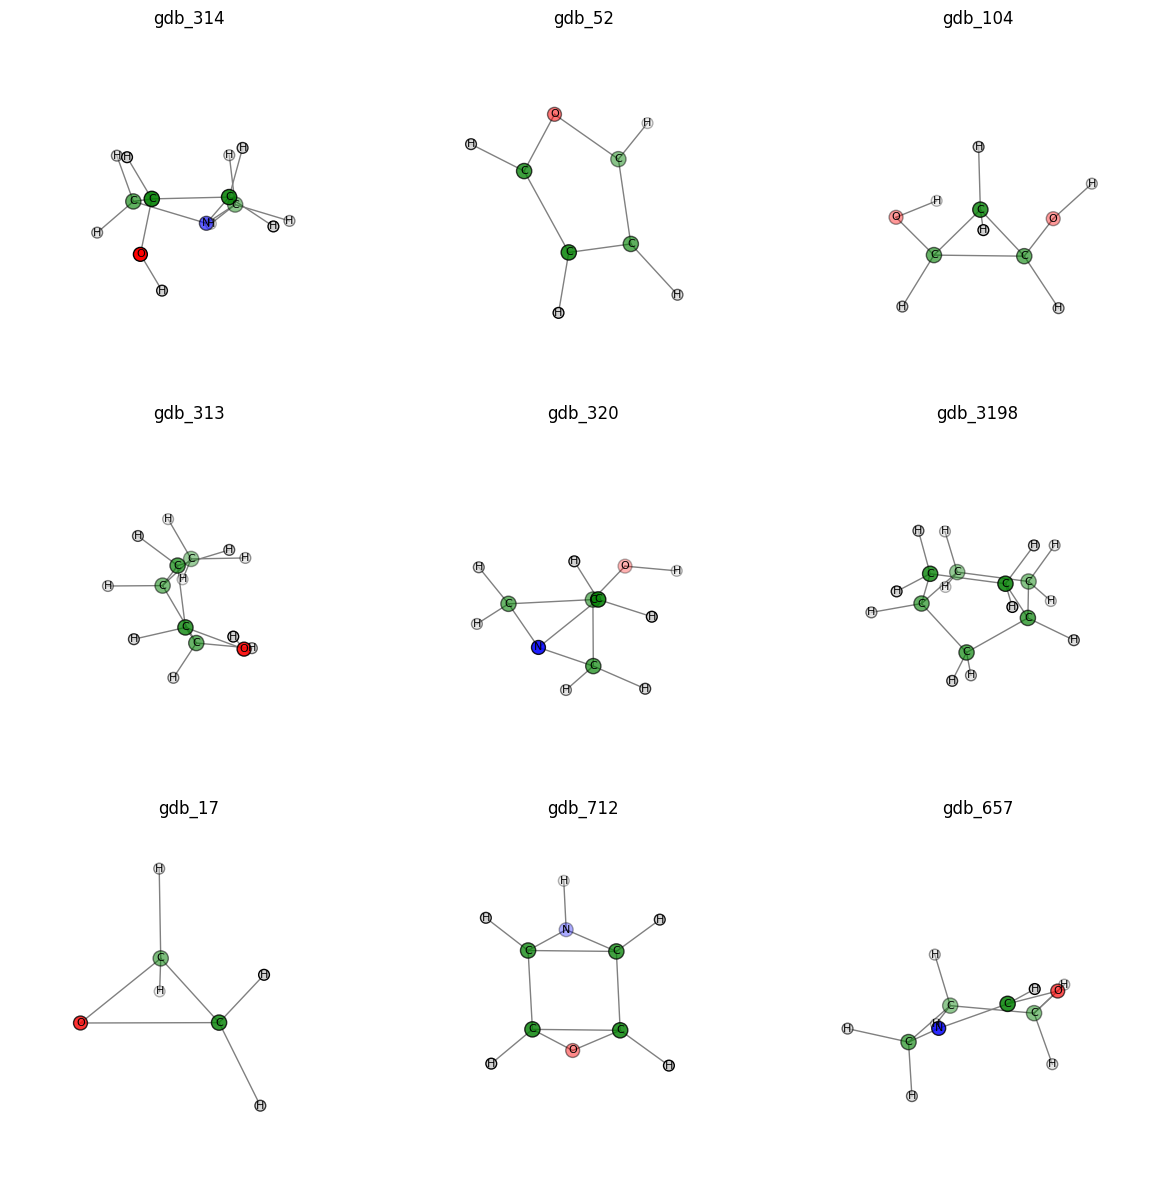

In [198]:
import random

# Plot a 3x3 grid of molecules from the existing `entries` list.
# Uses matplotlib (already imported) and the data objects already in the notebook.

n_rows, n_cols = 3, 3
mol_count = n_rows * n_cols
entries = high_ratio_entries.copy()
# entries = close_to_one_entries.copy()
random.shuffle(entries)
mols = entries[:mol_count]  # pick first 9 molecules; change slice if you want different ones

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12), subplot_kw={'projection': '3d'})
axs = axs.ravel()

# element symbol / color mapping (same as used in visualize_graph)
elem_sym = {1: "H", 6: "C", 7: "N", 8: "O", 9: "F"}
color_map = {1: "lightgray", 6: "green", 7: "blue", 8: "red", 9: "cyan"}

for i, data in enumerate(mols):
    ax = axs[i]
    pos = data.pos.cpu().numpy()
    atomic_nums = data.z.cpu().numpy() if hasattr(data, "z") else None

    # draw edges (avoid duplicating undirected edges)
    edge_index = data.edge_index.cpu().numpy()
    edges = set()
    for u, v in edge_index.T:
        a, b = int(min(u, v)), int(max(u, v))
        edges.add((a, b))
    for u, v in edges:
        xs = pos[[u, v], 0]
        ys = pos[[u, v], 1]
        zs = pos[[u, v], 2]
        ax.plot(xs, ys, zs, color="gray", linewidth=1)

    # node colors / sizes
    colors = [color_map.get(int(a), "purple") for a in atomic_nums]
    sizes = [120 if int(a) == 6 else 60 if int(a) == 1 else 100 for a in atomic_nums]
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c=colors, s=sizes, edgecolors="k", depthshade=True)

    # optional atom labels
    for j, p in enumerate(pos):
        ax.text(p[0], p[1], p[2], elem_sym.get(int(atomic_nums[j]), str(int(atomic_nums[j]))),
                fontsize=8, horizontalalignment="center", verticalalignment="center")

    ax.set_title(getattr(data, "name", f"mol_{i}"))
    ax.set_axis_off()
plt.tight_layout()
plt.show()

In [178]:
import pandas as pd

# np.mean([ data.x for data in high_ratio_entries ][0].cpu().numpy(), axis=0)

final_list = []
for entry in high_ratio_entries:
    try:
        mean_values = np.mean(entry.x.cpu().numpy(), axis=0)
        has_high_ratio = True
        final_list.append((entry.name, has_high_ratio, *mean_values))
    except AttributeError as e:
        print(f"Error processing entry: {e}")

for entry in close_to_one_entries:
    try:
        mean_values = np.mean(entry.x.cpu().numpy(), axis=0)
        has_high_ratio = False
        final_list.append((entry.name, has_high_ratio, *mean_values))
    except AttributeError as e:
        print(f"Error processing entry: {e}")

df = pd.DataFrame(final_list)
df

Error processing entry: 'GlobalStorage' object has no attribute 'numpy'


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,gdb_3099,True,0.666667,0.333333,0.000000,0.000000,0.0,2.666667,0.0,0.0,0.0,0.0,0.666667
1,gdb_320,True,0.538462,0.307692,0.076923,0.076923,0.0,3.538461,0.0,0.0,0.0,0.0,0.538462
2,gdb_13241,True,0.500000,0.312500,0.125000,0.062500,0.0,3.750000,0.0,0.0,0.0,0.0,0.500000
3,gdb_16039,True,0.529412,0.411765,0.058824,0.000000,0.0,3.411765,0.0,0.0,0.0,0.0,0.529412
4,gdb_606,True,0.500000,0.416667,0.000000,0.083333,0.0,3.666667,0.0,0.0,0.0,0.0,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8471,gdb_41168,False,0.500000,0.388889,0.055556,0.055556,0.0,3.666667,0.0,0.0,0.0,0.0,0.500000
8472,gdb_67533,False,0.400000,0.400000,0.000000,0.200000,0.0,4.400000,0.0,0.0,0.0,0.0,0.400000
8473,gdb_94828,False,0.526316,0.368421,0.000000,0.105263,0.0,3.578947,0.0,0.0,0.0,0.0,0.526316
8474,gdb_75054,False,0.470588,0.294118,0.117647,0.117647,0.0,4.000000,0.0,0.0,0.0,0.0,0.470588


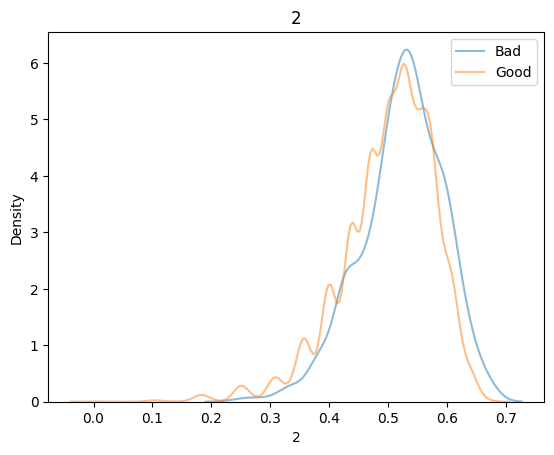

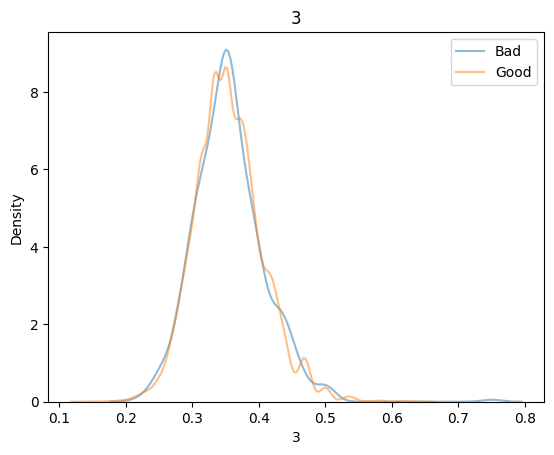

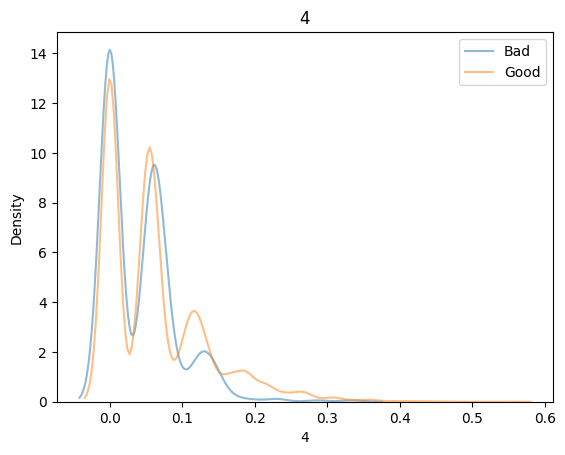

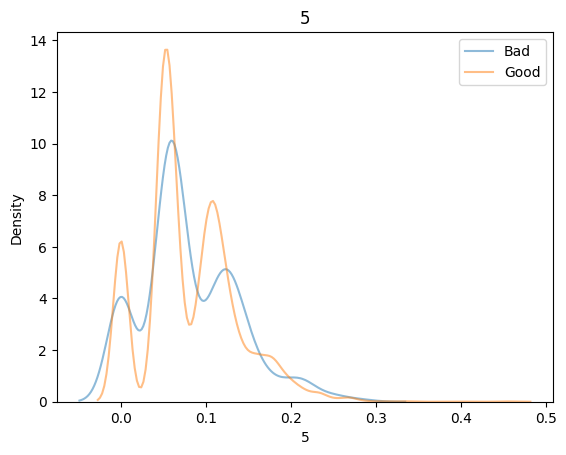

/tmp/ipykernel_10588/62397089.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df[1] == True][col], alpha=0.5, label="Bad")


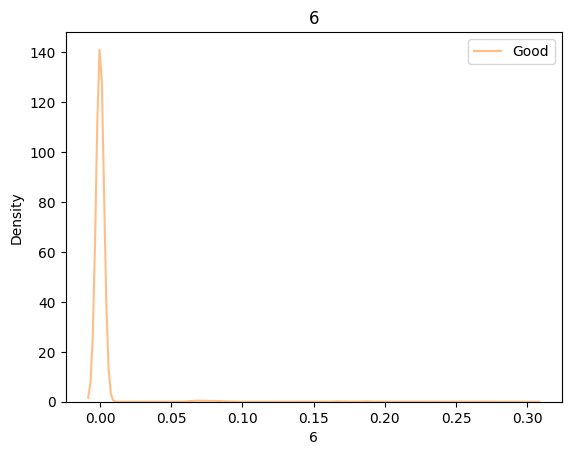

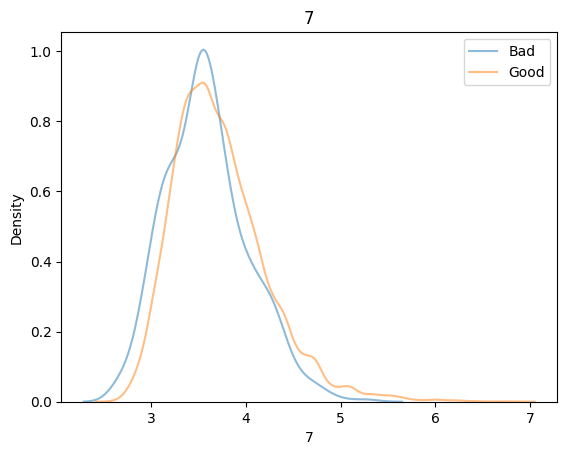

/tmp/ipykernel_10588/62397089.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df[1] == True][col], alpha=0.5, label="Bad")
/tmp/ipykernel_10588/62397089.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df[1] == False][col], alpha=0.5, label="Good")
/tmp/ipykernel_10588/62397089.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


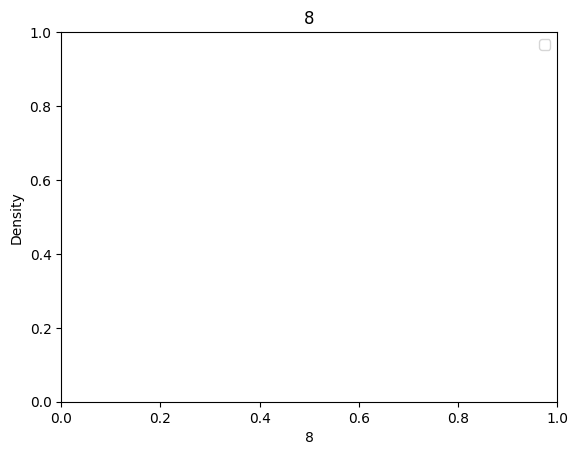

/tmp/ipykernel_10588/62397089.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df[1] == True][col], alpha=0.5, label="Bad")
/tmp/ipykernel_10588/62397089.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df[1] == False][col], alpha=0.5, label="Good")
/tmp/ipykernel_10588/62397089.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


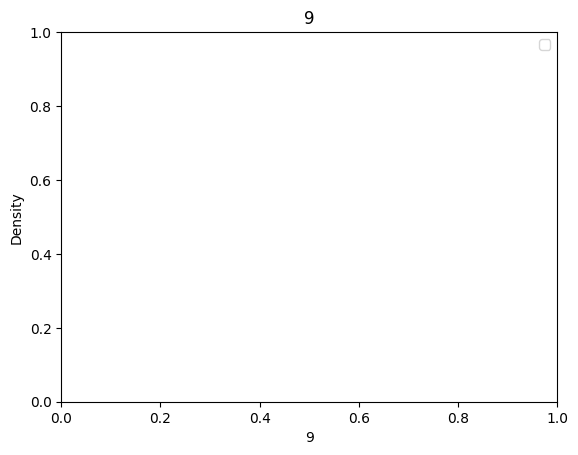

/tmp/ipykernel_10588/62397089.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df[1] == True][col], alpha=0.5, label="Bad")
/tmp/ipykernel_10588/62397089.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df[1] == False][col], alpha=0.5, label="Good")
/tmp/ipykernel_10588/62397089.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


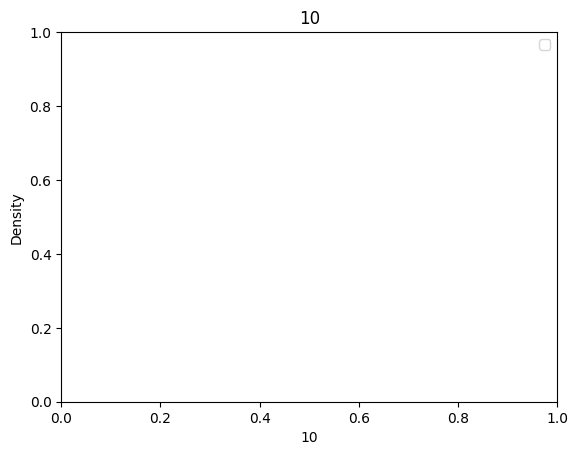

/tmp/ipykernel_10588/62397089.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df[1] == True][col], alpha=0.5, label="Bad")
/tmp/ipykernel_10588/62397089.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df[1] == False][col], alpha=0.5, label="Good")
/tmp/ipykernel_10588/62397089.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


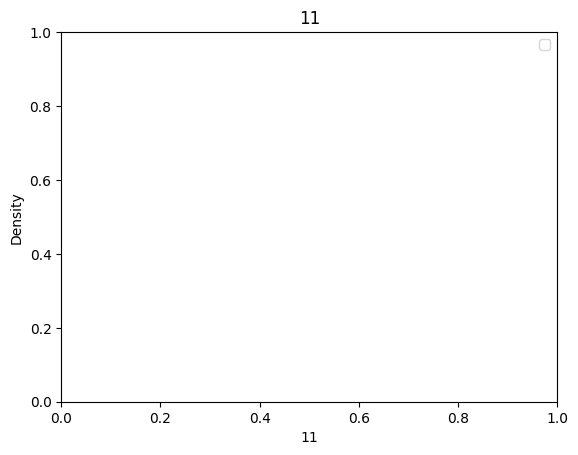

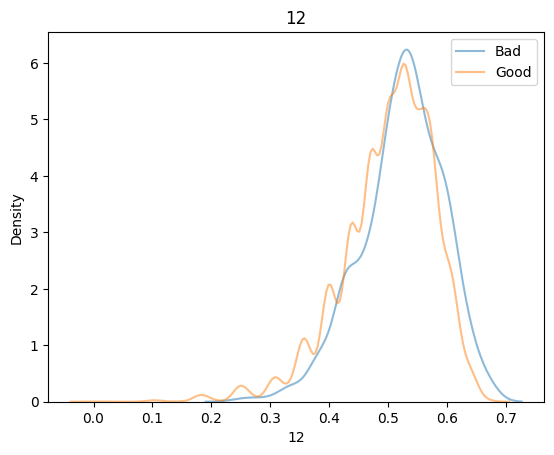

In [183]:
import seaborn as sns

for col in df.columns[2:]:  # skip is_bad
    plt.figure()
    sns.kdeplot(df[df[1] == True][col], alpha=0.5, label="Bad")
    sns.kdeplot(df[df[1] == False][col], alpha=0.5, label="Good")
    plt.title(col)
    plt.legend()
    plt.show()

# TODO:
- Implement edge features
- Use SchnNet, DimeNet or GemNet
- Implement geometrical information
- Use Huber loss
- Use scaffold split or substructure-based split insetaed of random (QM9 is not iid)

- When to use cross-validation
